# Initial setup
Import libraries and set up connections (GPIO, serial, video source)

In [1]:
print("======== Initial setup start... ========")
import time
from IPython.display import display, clear_output
import torch
print("torch version:", torch.__version__)
import torchreid
print("torchreid version:", torchreid.__version__)
import cv2
print("cv2 version:", cv2.__version__)
import numpy as np
import matplotlib.pyplot as plt
from torchreid.utils import FeatureExtractor
import Jetson.GPIO as GPIO
from jetson_inference import detectNet
from jetson_utils import videoSource, cudaToNumpy
import serial

cap = videoSource("/dev/video0")

# set up GPIO pins
GPIO.setmode(GPIO.BOARD)
GREEN_LED_PIN = 38
RED_LED_PIN = 37
BUTTON_PIN = 36
BUZZER_PIN = 35
GPIO.setup(GREEN_LED_PIN, GPIO.OUT)
GPIO.setup(RED_LED_PIN, GPIO.OUT)
GPIO.setup(BUTTON_PIN, GPIO.IN)
GPIO.setup(BUZZER_PIN, GPIO.OUT)

# GPIO functions
def turn_on_green_led():
    GPIO.output(GREEN_LED_PIN, GPIO.HIGH)

def turn_off_green_led():
    GPIO.output(GREEN_LED_PIN, GPIO.LOW)

def turn_on_red_led():
    GPIO.output(RED_LED_PIN, GPIO.HIGH)

def turn_off_red_led():
    GPIO.output(RED_LED_PIN, GPIO.LOW)

def lil_buzz():
    GPIO.output(BUZZER_PIN, GPIO.HIGH)
    time.sleep(0.2)
    GPIO.output(BUZZER_PIN, GPIO.LOW)

turn_on_red_led()
turn_on_green_led()

arduino = serial.Serial(
    port = '/dev/ttyACM0',
    baudrate = 9600,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=5,
    xonxoff=False,
    rtscts=False,
    dsrdtr=False,
    write_timeout=2
)

print("======== Initial setup complete. ========")

======== Initial setup start... ========
torch version: 1.10.0


/usr/local/lib/python3.6/dist-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


torchreid version: 1.4.0
cv2 version: 4.5.0
======== Initial setup complete. ========


### Initialize models
Feature extractor, person/object detector

In [2]:
print("======== Initializing models... ========")

# set device
device = torch.device("cuda")

# initialize the feature extractor
model_name = 'osnet_x1_0'
extractor = FeatureExtractor(
    model_name=model_name,
    device=str(device)
)

detect_net = detectNet("ssd-mobilenet-v2", threshold=0.5)

print("======== Finished loading models. ========")

======== Initializing models... ========
Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
======== Finished loading models. ========


### Function definitions
Image preprocessing, movement commands, etc

In [3]:
print("======== Declaring functions... ========")

# capture frame function
def capture_frame():
    return cap.Capture()

# preprocess image function
def preprocess_image(frame):
    frame_numpy = cudaToNumpy(frame)
    img = cv2.cvtColor(frame_numpy, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512, 256))
    img = np.transpose(img, (2, 0, 1)).astype(np.float32) / 255.0
    img = torch.tensor(img).unsqueeze(0).to(device)
    return img

# extract features function
def extract_features(frame):
    img = preprocess_image(frame)
    features = extractor(img)
    return features.squeeze().cpu().detach().numpy()

# cosine similarity function
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# movement control function
def send_movement_command(direction, distance):
    if direction < -0.5:
        print("Turning left")
        arduino.write("LEFT|".encode())
        # Send left arrow key press to Arduino
        # serial_connection.write(b'L')
    elif direction > 0.5:
        print("Turning right")
        arduino.write("RIGHT|".encode())
        # Send right arrow key press to Arduino
        # serial_connection.write(b'R')
    else:
        print("Moving forward")
        arduino.write("FORWARD|".encode())
        # Send up arrow key press to Arduino
        # serial_connection.write(b'F')

def get_person_center_and_width(frame, detect_net):
    detections = detect_net.Detect(frame)
    person_detections = [d for d in detections if d.ClassID == 1]
    if not person_detections:
        return None, None
    largest_detection = max(person_detections, key=lambda d: d.Width * d.Height)
    center_x = largest_detection.Center[0]
    center_y = largest_detection.Center[1]
    width = largest_detection.Width
    return (center_x, center_y), width

def determine_direction(center_x, frame_width):
    direction = (center_x - frame_width / 2) / (frame_width / 2) - 1
    return direction


def wait():
    for _ in range(3):
        turn_on_green_led()
        time.sleep(0.5)
        turn_off_green_led()
        time.sleep(0.5)
        
print("======== Function declaration complete. ========")

======== Declaring functions... ========
======== Function declaration complete. ========


### Model warm-up
Capture an initial frame from the camera and run models on it. Speeds up subsequent calls.

======== Warming up model... ========


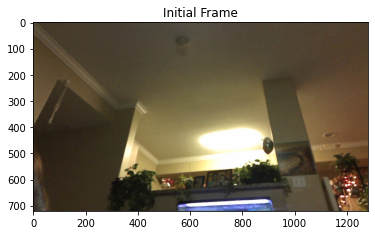

Person width: None
======== Warm up complete. ========


In [4]:
print("======== Warming up model... ========")
initial_frame = capture_frame()
plt.imshow(cudaToNumpy(initial_frame))
plt.title("Initial Frame")
plt.show()

initial_features = extract_features(initial_frame)
initial_center, initial_width = get_person_center_and_width(initial_frame, detect_net)
print("Person width:", initial_width)

turn_off_red_led()
turn_on_green_led()

print("======== Warm up complete. ========")

# Program start
Begin capturing person's features by pressing the button. After a few seconds, an image is captured and the person's features are extracted.

The person's features are captured a second time to improve results (ideally, the person would turn around so they can be identified from behind as well).

======== Capturing features... ========


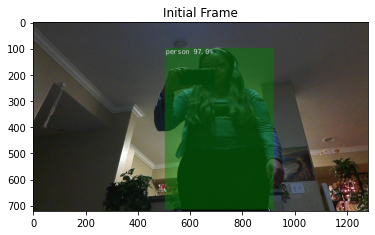

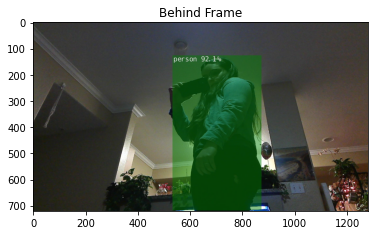

======== Feature capture complete. ========


In [7]:
print("======== Capturing features... ========")
while GPIO.input(BUTTON_PIN) == GPIO.LOW:
    time.sleep(0.1)

wait()

turn_off_green_led()
turn_on_red_led()

initial_frame = capture_frame()
if initial_frame is None:
    raise Exception("Could not capture initial frame")
center_test, width_test = get_person_center_and_width(initial_frame, detect_net)
while center_test is None:
    initial_frame = capture_frame()
    center_test, width_test = get_person_center_and_width(initial_frame, detect_net)
    
lil_buzz()
plt.imshow(cudaToNumpy(initial_frame))
plt.title("Initial Frame")
plt.show()
initial_features = extract_features(initial_frame)

wait()
    
behind_frame = capture_frame()

lil_buzz()

center_test, width_test = get_person_center_and_width(behind_frame, detect_net)
while center_test is None:
    behind_frame = capture_frame()
    center_test, width_test = get_person_center_and_width(behind_frame, detect_net)

plt.imshow(cudaToNumpy(behind_frame))
plt.title("Behind Frame")
plt.show()
behind_features = extract_features(behind_frame)

WIDTH_THRESHOLD = width_test

print("======== Feature capture complete. ========")

In [8]:
loop_count = 0
loop_max = 3
threshold = 0.7
total_width = 0
width_count = 0
total_direction = 0
direction_count = 0
consecutive_low_width_count = 0
turn_off_red_led()
turn_on_green_led()
none_count = 0
flag_forward = 0

arduino.write("STOP|".encode())

while True:
    loop_start_time = time.time()
    current_frame = capture_frame()
    if none_count == 5:
        arduino.write("STOP|".encode())
        flag_forward = False
        none_count = 0
    if current_frame is None:
        none_count += 1
        continue

    center, current_width = get_person_center_and_width(current_frame, detect_net)
    if center is None:
        none_count += 1
        continue
    if center is not None:
        current_features = extract_features(current_frame)
        similarity_front = cosine_similarity(initial_features, current_features)
        similarity_behind = cosine_similarity(behind_features, current_features)
        similar = similarity_front > threshold or similarity_behind > threshold

        if similar:
            total_width += current_width
            width_count += 1
            if current_width <= WIDTH_THRESHOLD:
                consecutive_low_width_count += 1
            elif flag_forward and (current_width > WIDTH_THRESHOLD):
                arduino.write("STOP|".encode())
                flag_forward = False
            else:
                consecutive_low_width_count = 0

            direction = determine_direction(center[0], 640)
            total_direction += direction
            direction_count += 1

        if loop_count % loop_max == 0:
            loop_count = 0
            avg_width = total_width / float(width_count) if width_count else 0
            avg_direction = total_direction / float(direction_count) if direction_count else 0

            if similar:
                print("Same person detected")
                print("Avg. width: ", avg_width)
                print("Avg. direction: ", avg_direction)
                
                if consecutive_low_width_count >= 3:
                    distance = WIDTH_THRESHOLD - avg_width
                    send_movement_command(avg_direction, distance)
                    consecutive_low_width_count = 0
                    flag_forward = True

            print(f"Overall loop time: {time.time() - loop_start_time:.4f}s")

            total_width = 0
            width_count = 0
            total_direction = 0
            direction_count = 0

            clear_output(wait=True)

        loop_count += 1

cv2.destroyAllWindows()
GPIO.cleanup()


KeyboardInterrupt: 

### Program Cleanup

In [ ]:
GPIO.cleanup()
cv2.destroyAllWindows()